In [2]:
%matplotlib inline

# Ultrasound imaging simulation

Ultrasound imaging is a medical imaging technique that uses sound waves to create visual representations of internal body structures. It is widely used in various medical fields, including obstetrics and cardiology, for diagnostic purposes. The technology relies on the principle that sound waves can penetrate and scatter off tissues, generating echoes that are then used to create detailed images.

Ultrasound can be used to measure many different phenomena. Here, we will demonstrate the most common type of ultrasound imaging: B-Mode. B-Mode imaging consists of 3 steps:
1. transmit pulse: a transducer emits high-frequency sound waves into the body. These waves are reflected by large tissue boundaries and diffusely scattered by small irregularities (e.g. cell boundaries).
2. receive echo: some of these sound waves echo back to the transducer, which records and digitizes them.
3. reconstruct image: a "beamforming" algorithm converts the pressure time-series into an image of the tissue.

Just as we can use NDK to simulate sound waves for focused ultrasound, we can use NDK to simulate the transmitted and received sound waves for ultrasound imaging. Ultrasound imaging simulations allow us to easily manipulate parameters, such as frequency and focal point, and see how they affect the resulting image.

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm.notebook

import neurotechdevkit as ndk
from neurotechdevkit.sources import PhasedArraySource2D
from neurotechdevkit.scenarios.built_in import Scenario3

# # Imaging modules
# from neurotechdevkit.imaging import demodulate, beamform, util

In [4]:
# Scenario parameters
SPEED_OF_SOUND_WATER = 1500  # meters per second
WATER_HETEROGENEITY = 1.0  # arbitrary units, determines how much the acoustic impedance varies in the water
# Increasing WATER_HETEROGENEITY increases the amount of speckle in the image due to increased scattering.

# Plane-wave pulse parameters
TONE_CENTER_FREQUENCY = 0.5e6  # Hz
TILT_ANGLES_DEG = np.linspace(start=-10, stop=10, endpoint=True, num=21)  # Plane-wave pulses

# Phased array transducer parameters
ARRAY_PITCH = 300e-6  # meters
ARRAY_ELEMENT_WIDTH = 270e-6  # meters
ARRAY_NUM_ELEMENTS = 128
TRANSDUCER_6DB_PULSE_ECHO_FRACTIONAL_BANDWIDTH = 0.5  # transmit/receive frequency bandwidth as a fraction of center frequency

RANDOM_SEED = 58295  # Use if we need the specific function to be deterministic
rng = np.random.default_rng(seed=RANDOM_SEED)  # Use if we only need the notebook to be deterministic

## Define the scenario

Ultrasound imaging measures the scattering of sound waves, which occur due to changes in acoustic impedance (speed and density). In normal tissue, these changes occur across different scales. Large tissue boundaries cause specular scattering, and microscopic heterogeneities cause diffuse scattering. 

To mimic these properties, we create ultrasound phantoms that are similarly heterogenous across different scales. Their bulk acoustic impedance differs from the background medium (water), and their within-phantom impednances also vary at small scales.

For the transducer, we choose a phased array that can both steer ultrasonic waves and record independently at multiple elements.

We visualize the scenario layout with the material masks and then visualize the acoustic properties that affect wave scattering and propagation.

creating a grid with shape: (201, 201) for extent: [0.1 0.1] m


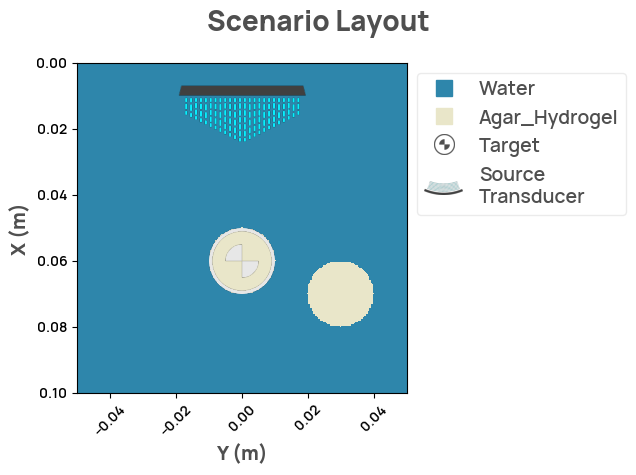

In [6]:
def create_scenario(tilt_angle: float = 0.0) -> Scenario3:
    """Helper function to initialize scenario with different tilt angles."""
    scenario = Scenario3()
    scenario.center_frequency = TONE_CENTER_FREQUENCY
    scenario.sources = [
        PhasedArraySource2D(
            position=[0.003, 0.0],
            direction=[1.0, 0.0],
            num_elements=ARRAY_NUM_ELEMENTS,
            num_points=ARRAY_NUM_ELEMENTS * 4,
            tilt_angle=0,
            pitch=ARRAY_PITCH,
            element_width=ARRAY_ELEMENT_WIDTH,
        )
    ]
    scenario.make_grid()
    scenario.compile_problem()
    return scenario

scenario = create_scenario()
scenario.render_layout()

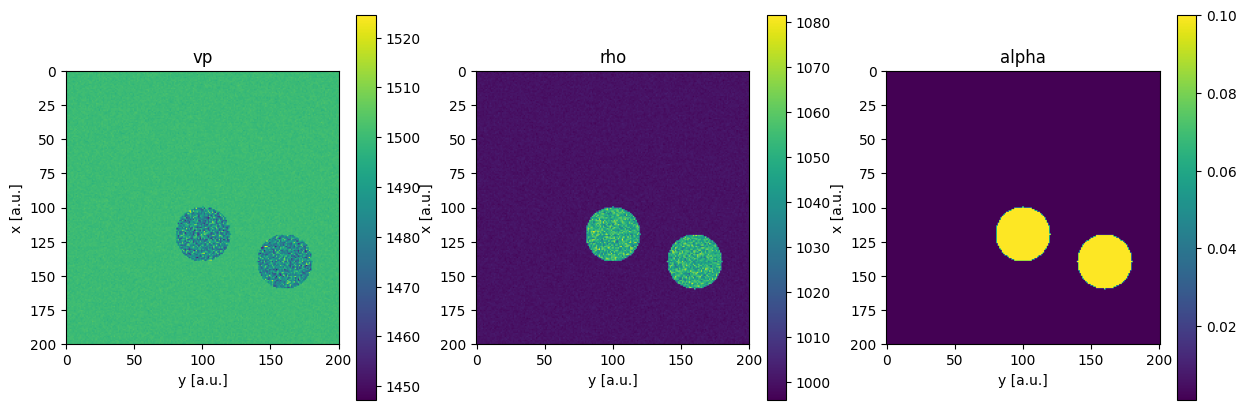

In [6]:
# Plot the relevant material metrics
fig,axs = plt.subplots(1,3,figsize=(15,5))

for idx, attribute in enumerate(["vp", "rho", "alpha"]):
    im = axs[idx].imshow(getattr(scenario.problem.medium, attribute).data)
    plt.colorbar(im, ax=axs[idx])
    axs[idx].set_title(attribute)
    axs[idx].set_xlabel("y [a.u.]")
    axs[idx].set_ylabel("x [a.u.]")

We can see the bulk contrast between the background medium and the phantoms.

Speed-of-sound (`vp`) and density (`rho`) determine a material's "acoustic impedance." Changes in acoustic impedance determine how ultrasound waves scatter, while attenuation (`alpha`) determines how far ultrasound waves into a medium.

## 1. Transmit pulse

### Visualize beam

To create a 2-D ultrasound image, a common approach is to emit a focused beam at a single horizontal position, effectively creating a 1-D depth image, and then repeat at different horizontal positions. We take this approach here, but for simplicity only simulate a single pulse.

Let's verify that the transducer focuses along a single line. This will be the line that receives the most ultrasonic energy and thus will reflect the strongest echoes.

creating a grid with shape: (201, 201) for extent: [0.1 0.1] m
Estimated time to complete simulation: 48 seconds. Memory required is 8.112980893321803 GB (available 68.719476736 GB). These values are approximated.
Default Devito configuration:
	 * autotuning=off
	 * develop-mode=False
	 * mpi=False
	 * log-level=DEBUG
	 * language=openmp
(ShotID 0) Preparing to run state for shot
(ShotID 0) Estimated bandwidth for the propagated wavelet 0.498-0.503 MHz
(ShotID 0) Spatial grid spacing (0.500 mm | 5.760 PPW) is below dispersion limit (0.576 mm | 5.000 PPW)
(ShotID 0) Time grid spacing (0.083 μs | 25%) is below OT2 limit (0.148 μs)
(ShotID 0) Selected undersampling level 4
(ShotID 0) Selected time stepping scheme OT2
Operator `acoustic_iso_state` instance configuration:
	 * subs={h_x: 0.0005, h_y: 0.0005}
	 * opt=advanced
	 * platform=None
Operator `acoustic_iso_state` generated in 4.25 s
  * lowering.Clusters: 2.27 s (53.5 %)
     * specializing.Clusters: 1.31 s (30.9 %)
  * lowering.Exp

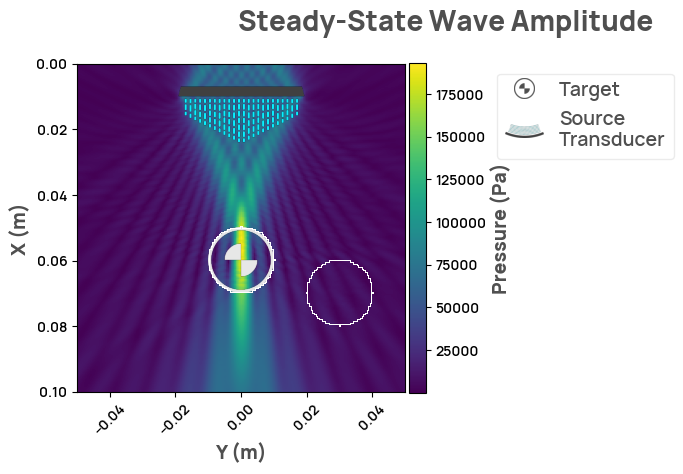

In [7]:
result = scenario.simulate_steady_state()
result.render_steady_state_amplitudes()

In [8]:
# Run pulse for imaging
result = scenario.simulate_pulse(
    center_frequency=TONE_CENTER_FREQUENCY,
    n_jobs=-2,
)

creating a grid with shape: (201, 201) for extent: [0.1 0.1] m
Memory and time requirement estimations do not currently support pulsed simulations, so none will be provided.
Default Devito configuration:
	 * autotuning=off
	 * develop-mode=False
	 * mpi=False
	 * log-level=DEBUG
	 * language=openmp
(ShotID 0) Preparing to run state for shot
(ShotID 0) Estimated bandwidth for the propagated wavelet 0.256-0.732 MHz
(ShotID 0) Spatial grid spacing (0.500 mm | 3.952 PPW) is higher than dispersion limit (0.395 mm | 5.000 PPW)
(ShotID 0) Time grid spacing (0.083 μs | 25%) is below OT2 limit (0.148 μs)
(ShotID 0) Selected undersampling level 1
(ShotID 0) Selected time stepping scheme OT2
Operator `acoustic_iso_state` instance configuration:
	 * subs={h_x: 0.0005, h_y: 0.0005}
	 * opt=advanced
	 * platform=None
Operator `acoustic_iso_state` generated in 4.12 s
  * lowering.Clusters: 2.31 s (56.1 %)
     * specializing.Clusters: 1.39 s (33.8 %)
  * lowering.Expressions: 0.97 s (23.6 %)
Flops re

## 2. Receive echo
(This is actually already included in `scenario.simulate_pulse`)

## Visualizing received (simulated) signals

While NDK does provide us the entire wavefield, in a real imaging situation, we usually only have access to the "radiofrequency signals," the raw signals measured at the ultrasound sensor elements. Let's visualize them.

In [9]:
# The receivers at N sensor elements give us data traces of [N, num_fast_time_samples]
num_channels = result.shot.num_receivers
assert num_channels > 0
time_arr = result.traces.time.grid
assert result.traces.data.shape == (
    num_channels,
    len(time_arr)
)

print("Traces shape:", result.traces.data.shape)
print("Time grid:", time_arr)
freq_sampling = 1 / result.traces.time.step
print("Sampling frequency [Hz]: {:.2e}".format(freq_sampling))

Traces shape: (128, 2343)
Time grid: [0.0000000e+00 8.3333333e-08 1.6666667e-07 ... 1.9500000e-04 1.9508334e-04
 1.9516666e-04]
Sampling frequency [Hz]: 1.20e+07


In [10]:
# Reshape to [time, channels] shape
rf_signals = result.traces.data.T  

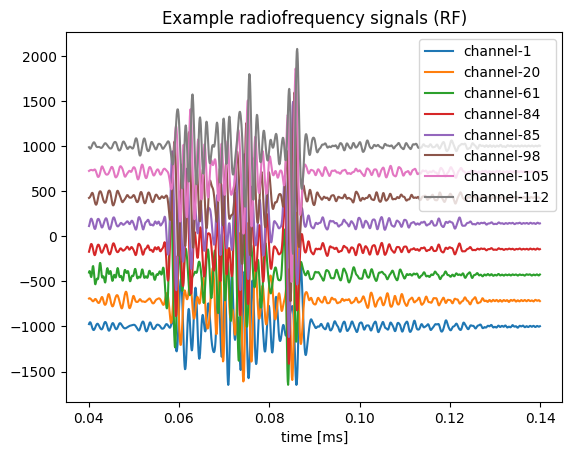

In [11]:
NUM_VISUALIZE = 8
channel_idxs = rng.integers(num_channels, size=NUM_VISUALIZE)
channel_idxs.sort()

time_mask = (40e-6 < time_arr) & (time_arr < 140e-6)
# time_mask = time_arr > 0

# Plot with some offsets
_ = plt.plot(
    time_arr[time_mask] * 1000,
    rf_signals[time_mask][:, channel_idxs] + np.linspace(-1000, 1000, num=NUM_VISUALIZE, endpoint=True),
    label=[f"channel-{channel_idx}" for channel_idx in channel_idxs],
)
_ = plt.legend()
_ = plt.title("Example radiofrequency signals (RF)")
_ = plt.xlabel("time [ms]")
_ = plt.ylabel("amplitude and channel offset [a.u]")

The transmitted signals consisted of a high-frequency pulse, so the received RF signals are similarly modulated by the same carrier frequency. The signals are strongest about 6-9ms after the pulse transmission.

The received amplitudes here scale with the transmit pulse, which currently has an arbitrary amplitude. Later down, we rescale the image anyways, so we won't worry about absolute amplitudes here.

## 3. Reconstruct image

### 3a. Demodulate radiofrequency (RF) signals to in-phase/quadrature (I/Q)

Next, we extract the lower-frequency envelope from the radiofrequency signals. One can think of this lower-frequency envelope as matching the spatial frequency of the image.

There are two slight variants of this initial signal processing step: quadrature detection (I/Q) or analytic (Hilbert transform). I/Q is traditionally more common in real-time systems, so we will show it here. https://starfishmedical.com/blog/pros-cons-two-popular-ultrasound-signal-processing-techniques/ provides a nice comparison of the two methods.

I/Q demodulates the center/carrier frequency from the RF signal to extract the lower-frequency envelope as a complex signal.

In [12]:
iq_signals, freq_carrier_est = demodulate.demodulate_rf_to_iq(
    rf_signals,
    freq_sampling,
    freq_carrier=TONE_CENTER_FREQUENCY,
    bandwidth=TRANSDUCER_6DB_PULSE_ECHO_FRACTIONAL_BANDWIDTH,
)

assert iq_signals.shape == rf_signals.shape

Text(0.5, 0, 'time [ms]')

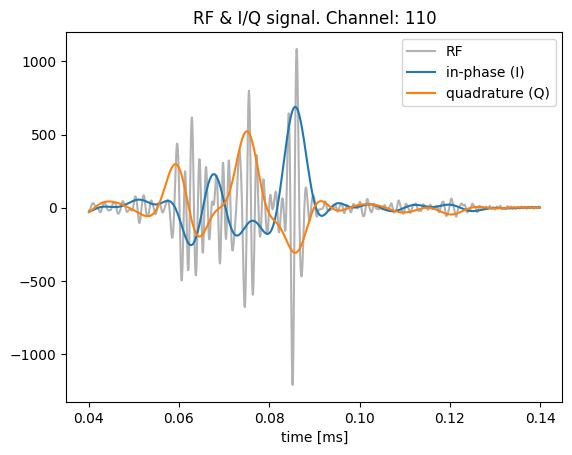

In [13]:
# Plot the lower-frequency I/Q signals over the RF signal
channel_idx = rng.integers(num_channels)  # Pick one of the earlier channels? random choice?
# zoom in on time-window

fig, ax = plt.subplots()
ax.plot(
    time_arr[time_mask] * 1000,
    rf_signals[time_mask, channel_idx],
    color='k',
    alpha=0.3,
    label='RF',
)
ax.plot(
    time_arr[time_mask] * 1000,
    iq_signals[time_mask, channel_idx].real,
    label='in-phase (I)'
)
ax.plot(
    time_arr[time_mask] * 1000,
    iq_signals[time_mask, channel_idx].imag,
    label='quadrature (Q)'
)
ax.legend()
ax.set_title(f"RF & I/Q signal. Channel: {channel_idx}")
ax.set_xlabel("time [ms]")

### 3b. Beamform image
Let's use a common beamforming algorithm, `delay-and-sum`, to reconstruct an ultrasound image.

The intuition for `delay-and-sum` is that: if an object is at distance $d$ from a given transducer with speed-of-sound $c$, we should receive its scattered signal at time $\frac{d}{c}$ after it receives the ultrasound pulse. This is a similar idea to shouting in a cave, then waiting to hear the echo-time to determine how far away the wall is. In 2 or 3 dimensions, however, there are multiple points at the same distance that could be contributing to the echo signal. Delay-and-sum implicitly disassociates these confounded points by summing over the different receiver elements.

Note: beamforming can also work on the raw radiofrequency (RF) signals. However, the RF signals are higher-frequency and thus require additional computational power, so diagnostic B-mode scanners usually demodulate RF signals to I/Q first (as we did above).

In [14]:
# Beam-form I/Q signals into an image

assert len(scenario.sources) == 1
source = scenario.sources[0]
assert isinstance(source, ndk.sources.PhasedArraySource)
pitch = source.pitch
width = source.element_width
empirical_pitch = np.linalg.norm(np.diff(result.shot.receiver_coordinates, axis=0), axis=1)
np.testing.assert_allclose(empirical_pitch, pitch, rtol=1e-2)

# Generate an image at the scenario grid
# NOTE: .mesh uses different x/y space
x_mesh, y_mesh = result.shot.grid.space.mesh

# Switch to imaging convention: x for parallel-to-array, z for depth
imaging_x_mesh = y_mesh + scenario.origin[1]
imaging_z_mesh = x_mesh + scenario.origin[0]

iq_signals_beamformed = beamform.beamform_delay_and_sum(
    iq_signals,
    x=imaging_x_mesh,
    z=imaging_z_mesh,
    pitch=pitch,
    tx_delays=scenario.sources[0].element_delays,
    freq_sampling=freq_sampling,
    freq_carrier=TONE_CENTER_FREQUENCY,
    f_number=None,
    width=width,
    bandwidth=TRANSDUCER_6DB_PULSE_ECHO_FRACTIONAL_BANDWIDTH,
    speed_sound=SPEED_OF_SOUND_WATER,  # water
)
iq_signals_beamformed.shape

(201, 201)

## Visualize reconstructed image

In [18]:
def plot_ultrasound_image(x_mesh, z_mesh, iq_signals_bf, db=40):
    plt.pcolormesh(
        x_mesh,
        z_mesh,
        util.log_compress(iq_signals_bf, db),
        cmap='gray',
    )
    cbar = plt.colorbar(ticks=[0, 1])
    cbar.ax.set_yticklabels([f"-{db} dB", "0 dB"])  # horizontal colorbar

    plt.axis('equal')
    plt.gca().invert_yaxis()  # Invert the y-axis to flip the image vertically
    plt.title('Log-compressed image')
    plt.xlabel('[m]')
    plt.ylabel('[m]')

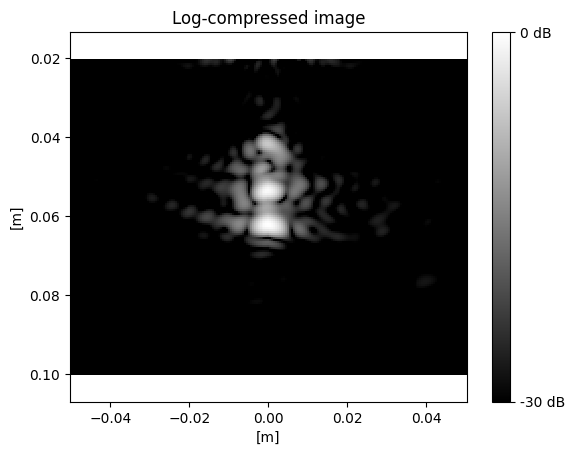

In [16]:
# Ignore the transducer elements
mask = (imaging_z_mesh > 0.02).all(axis=1)
plot_ultrasound_image(
    imaging_x_mesh[mask],
    imaging_z_mesh[mask],
    iq_signals_beamformed[mask],
    db=30,
)

Above shows the reconstruction of a single ultrasound scan line, focusing on $x = 0$ (e.g., see the steady-state amplitude, which shows where the pulse focuses). Because the phantom on the right is out of the focal point, it does not show up clearly in the image. Sweeping across different scan lines would allow reconstruction of a full 2D (or 3D) image.

The speckles in the image are a normal part of B-mode imaging. Further signal processing methods, such as harmonic imaging or compound-plane-wave imaging, can improve spatial resolution.

## Construct full image by sweeping scan-lines

Next, let's build on the previous example by constructing a wider field-of-view by sweeping different scan lines. We can use the phased-array to tilt the scan line radially and image different parts of the image space.

In [7]:
NUM_TILTS = 5
TILT_ANGLES_DEG = np.linspace(-40, 40, NUM_TILTS, endpoint=True)

In [8]:

scenario = ImagingCirclesScenario()

Let's compare the beam-focus of 2 different tilt angles

creating a grid with shape: (201, 201) for extent: [0.1 0.1] m
Estimated time to complete simulation: 47 seconds. Memory required is 8.113949413294987 GB (available 68.719476736 GB). These values are approximated.
Default Devito configuration:
	 * autotuning=off
	 * develop-mode=False
	 * mpi=False
	 * log-level=DEBUG
	 * language=openmp
(ShotID 0) Preparing to run state for shot
(ShotID 0) Estimated bandwidth for the propagated wavelet 0.499-0.499 MHz
(ShotID 0) Spatial grid spacing (0.500 mm | 5.795 PPW) is below dispersion limit (0.580 mm | 5.000 PPW)
(ShotID 0) Time grid spacing (0.083 μs | 25%) is below OT2 limit (0.148 μs)
(ShotID 0) Selected undersampling level 4
(ShotID 0) Selected time stepping scheme OT2
Operator `acoustic_iso_state` instance configuration:
	 * subs={h_x: 0.0005, h_y: 0.0005}
	 * opt=advanced
	 * platform=None
Operator `acoustic_iso_state` generated in 4.78 s
  * lowering.Clusters: 2.63 s (55.1 %)
     * specializing.Clusters: 1.58 s (33.1 %)
  * lowering.Exp

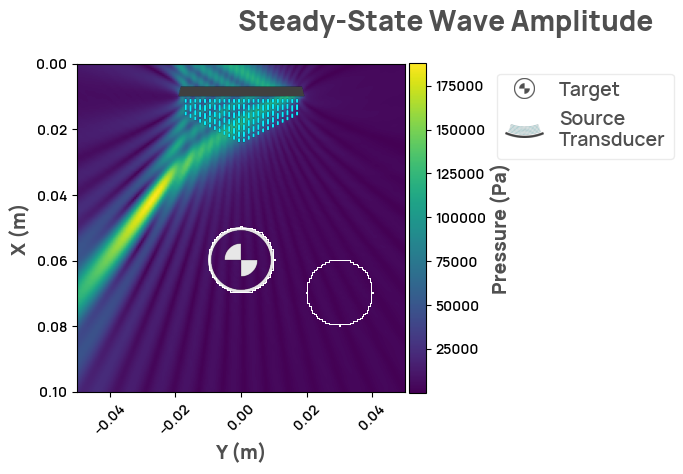

In [10]:
scenario = ImagingCirclesScenario()
scenario.add_source(scenario.get_default_source())
assert len(scenario.sources) == 1
scenario.sources[0].tilt_angle = TILT_ANGLES_DEG[0]
result = scenario.simulate_steady_state(
    center_frequency=TONE_CENTER_FREQUENCY,
)
result.render_steady_state_amplitudes()

creating a grid with shape: (201, 201) for extent: [0.1 0.1] m
Estimated time to complete simulation: 47 seconds. Memory required is 8.113949413294987 GB (available 68.719476736 GB). These values are approximated.
Default Devito configuration:
	 * autotuning=off
	 * develop-mode=False
	 * mpi=False
	 * log-level=DEBUG
	 * language=openmp
(ShotID 0) Preparing to run state for shot
(ShotID 0) Estimated bandwidth for the propagated wavelet 0.499-0.499 MHz
(ShotID 0) Spatial grid spacing (0.500 mm | 5.795 PPW) is below dispersion limit (0.580 mm | 5.000 PPW)
(ShotID 0) Time grid spacing (0.083 μs | 25%) is below OT2 limit (0.148 μs)
(ShotID 0) Selected undersampling level 4
(ShotID 0) Selected time stepping scheme OT2
Operator `acoustic_iso_state` instance configuration:
	 * subs={h_x: 0.0005, h_y: 0.0005}
	 * opt=advanced
	 * platform=None
Operator `acoustic_iso_state` generated in 4.94 s
  * lowering.Clusters: 2.65 s (53.7 %)
     * specializing.Clusters: 1.59 s (32.2 %)
  * lowering.Exp

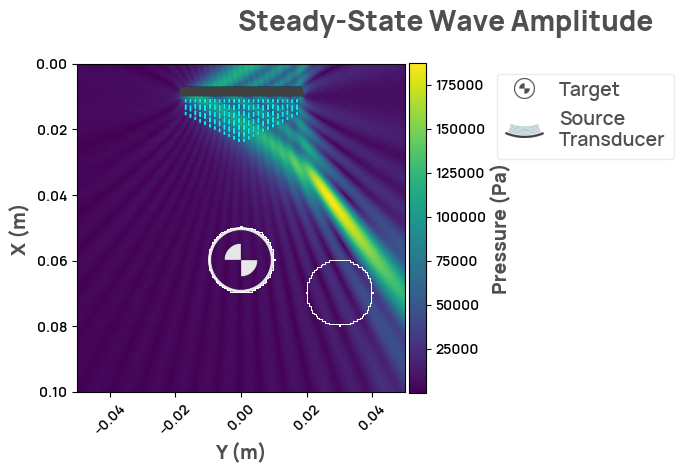

In [20]:
scenario = ImagingCirclesScenario()
scenario.add_source(scenario.get_default_source())
assert len(scenario.sources) == 1
scenario.sources[0].tilt_angle = TILT_ANGLES_DEG[-1]
result = scenario.simulate_steady_state(
    center_frequency=TONE_CENTER_FREQUENCY,
)
result.render_steady_state_amplitudes()

The steady-state figures show that the tilted ultrasound beams hit different parts of the image space.

Now, let's pulse at different scan lines and sum them together to reconstruct the image.

In [12]:
# Send several plane waves from the transducer and measure the reflected/scattered acoustic waves
# We can then compound the different plane waves to improve the spatial resolution

results = [None] * len(TILT_ANGLES_DEG)
# keep track of the tx delays used
element_delays_list = [None] * len(TILT_ANGLES_DEG)

for idx, tilt_angle in enumerate(tqdm.notebook.tqdm(TILT_ANGLES_DEG, desc="Simulating pulses", unit="pulse")):
    # Current limitation of NDK: need to re-generate scenario to simulate a new pulse
    # https://github.com/agencyenterprise/neurotechdevkit/issues/108
    scenario = ImagingCirclesScenario()
    scenario.add_source(scenario.get_default_source())
    assert len(scenario.sources) == 1
    # Set the tilt angle, which will automatically re-calculate the element delays
    scenario.sources[0].tilt_angle = tilt_angle
    element_delays_list[idx] = scenario.sources[0].element_delays
    results[idx] = scenario.simulate_pulse(
        center_frequency=TONE_CENTER_FREQUENCY,
        n_jobs=-2,
    )

Simulating pulses:   0%|          | 0/5 [00:00<?, ?pulse/s]

creating a grid with shape: (201, 201) for extent: [0.1 0.1] m
Memory and time requirement estimations do not currently support pulsed simulations, so none will be provided.
Default Devito configuration:
	 * autotuning=off
	 * develop-mode=False
	 * mpi=False
	 * log-level=DEBUG
	 * language=openmp
(ShotID 0) Preparing to run state for shot
(ShotID 0) Estimated bandwidth for the propagated wavelet 0.252-0.735 MHz
(ShotID 0) Spatial grid spacing (0.500 mm | 3.939 PPW) is higher than dispersion limit (0.394 mm | 5.000 PPW)
(ShotID 0) Time grid spacing (0.083 μs | 25%) is below OT2 limit (0.148 μs)
(ShotID 0) Selected undersampling level 1
(ShotID 0) Selected time stepping scheme OT2
Operator `acoustic_iso_state` instance configuration:
	 * subs={h_x: 0.0005, h_y: 0.0005}
	 * opt=advanced
	 * platform=None
Operator `acoustic_iso_state` generated in 5.07 s
  * lowering.Clusters: 2.77 s (54.8 %)
     * specializing.Clusters: 1.64 s (32.4 %)
  * lowering.Expressions: 1.20 s (23.8 %)
Flops re

Let's follow the same steps as above for reconstructing each scan-line image.

Stack the different scan-lines (sometimes called the "slow-time" dimension).

In [13]:
# Pad RF signals to longest length, in case they are not all the same length
rf_signal_lengths = [len(result.traces.time.grid) for result in results]
rf_signal_max_len = max(rf_signal_lengths)
rf_signal_max_len_idx = np.argmax(rf_signal_lengths)
time = results[rf_signal_max_len_idx].traces.time.grid

# Shape: [num_fast_time_samples, num_elements, num_pulses]
rf_signals = np.zeros(
    (rf_signal_max_len, ARRAY_NUM_ELEMENTS, len(results)),
    dtype=float,
)
for pulse_idx, result in enumerate(results):
    rf_signals[:rf_signal_lengths[pulse_idx], :, pulse_idx] = result.traces.data.T

Demodualte the RF signals to I/Q.

In [15]:
freq_sampling = 1 / result.traces.time.step
iq_signals, _ = demodulate.demodulate_rf_to_iq(
    rf_signals,
    freq_sampling,
    freq_carrier=TONE_CENTER_FREQUENCY,
    bandwidth=TRANSDUCER_6DB_PULSE_ECHO_FRACTIONAL_BANDWIDTH,
)

assert iq_signals.shape == rf_signals.shape

Beamform I/Q signals into an image

In [16]:
# Beam-form I/Q signals into an image

assert len(scenario.sources) == 1
source = scenario.sources[0]
assert isinstance(source, ndk.sources.PhasedArraySource)
pitch = source.pitch
width = source.element_width
empirical_pitch = np.linalg.norm(np.diff(results[0].shot.receiver_coordinates, axis=0), axis=1)
np.testing.assert_allclose(empirical_pitch, pitch, rtol=1e-2)

# Generate an image at the scenario grid
# NOTE: .mesh uses different x/y space
x_mesh, y_mesh = results[0].shot.grid.space.mesh

# Switch to imaging convention: x for parallel-to-array, z for depth
imaging_x_mesh = y_mesh + scenario.origin[1]
imaging_z_mesh = x_mesh + scenario.origin[0]

iq_signals_beamformed_list = []
for idx, tilt_angle in enumerate(TILT_ANGLES_DEG):
    iq_signals_beamformed = beamform.beamform_delay_and_sum(
        iq_signals[:, :, idx],
        x=imaging_x_mesh,
        z=imaging_z_mesh,
        pitch=pitch,
        tx_delays=element_delays_list[idx],
        freq_sampling=freq_sampling,
        freq_carrier=TONE_CENTER_FREQUENCY,
        f_number=None,
        width=width,
        bandwidth=TRANSDUCER_6DB_PULSE_ECHO_FRACTIONAL_BANDWIDTH,
        speed_sound=SPEED_OF_SOUND_WATER,  # water
    )
    iq_signals_beamformed_list.append(iq_signals_beamformed)

iq_signals_beamformed_compound = np.stack(iq_signals_beamformed_list, axis=-1)
iq_signals_beamformed_compound.shape

(201, 201, 5)

Text(0.5, 1.0, 'Multi-scan-line image')

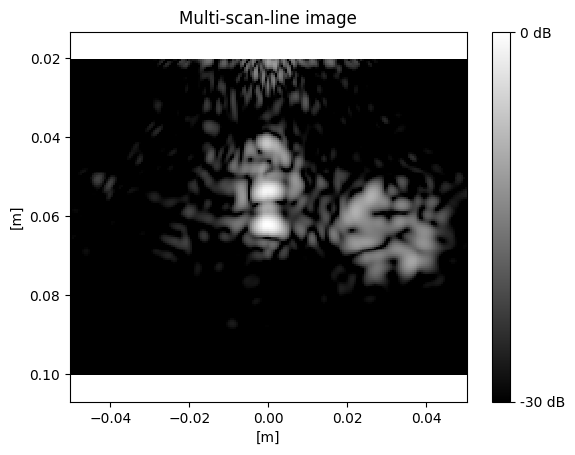

In [19]:
mask = (imaging_z_mesh > 0.02).all(axis=1)
plot_ultrasound_image(
    imaging_x_mesh[mask],
    imaging_z_mesh[mask],
    iq_signals_beamformed_compound[mask].sum(axis=-1),
    db=30,
)
plt.title("Multi-scan-line image")

The multi-scan-line image includes both phantoms. Notice, though, that the image of the center phantom is more intense where the scan line was focused. This resolution can be improved by sweeping scan lines that are closer together. Thus, the resolution is tightly coupled with the number of scan lines, analogous to raster-printing a photo.

In the next notebook, we will discuss a method to improve resolution with a fewer number of pulse-echos by using unfocused beams.